# Homework set 10 Comp Econ
## Figure replication from Matsuyama et al. (2014)

**Author** Pierre Mabille 

**NYU ID** N10017621 

**Date** April 29, 2016 

I replicate figure 9a of the paper *Globalization and synchronization of innovation cycles*, by Matsuyama, Sushko and Gardini (2014-12-18 version). I consider the case of 2 symmetric countries.

I load modules, define parameters and a function that computes the function $h(n)$ defined implicitly by $\frac{1}{h(n)+\rho n}+\frac{1}{h(n)+ n/\rho}=2$.

In [4]:
using NLsolve
using PyPlot
using QuantEcon

rho_range = [.2 .4 .6 .8]
T = 25
tol_synchronization = 1e-2

function h_rho(n, rho::Float64)
    function implicit_eqn!(h, fvec)
        fvec[1] = 1/(h[1]+rho*n) + 1/(h[1]+ n/rho) - 2
    end
    h_sol = nlsolve(implicit_eqn!, [.5])
    return h_sol.zero[1]
end

h_rho (generic function with 1 method)

Define a function that generates the series of product varieties $n_{1,t}$ and $n_{2,t}$, and simulate those series for various initial conditions $n_{1,0}$ and $n_{2,0}$. In the first case there is synchronization, but not in the second.

In [5]:
function generate_n(n1_init::Float64, n2_init::Float64, rho::Float64; 
    s1::Float64=.5, theta::Float64=2.5, delta::Float64=0.7, T::Int64=25)
    
    n = Array(Float64 ,2, T)
    # initial conditions from which synchronization may occur
    n[1,1] = n1_init
    n[2,1] = n2_init
    h(n) = h_rho(n, rho)
    for t in 1:T-1
        if n[1,t] <= s1 && n[2,t] <= s1
            n[1,t+1] = delta*(theta/2 + (1-theta)*n[1,t])
            n[2,t+1] = delta*(theta/2 + (1-theta)*n[2,t])
        elseif n[1,t] >= h(n[2,t]) && n[2,t] >= h(n[1,t])
            n[1,t+1] = delta*n[1,t]
            n[2,t+1] = delta*n[2,t]
        elseif n[1,t] >= s1 && n[2,t] <= h(n[1,t])
            n[1,t+1] = delta*n[1,t]
            n[2,t+1] = delta*(theta*h(n[1,t])+(1-theta)*n[2,t])
        elseif n[1,t] <= h(n[2,t]) && n[2,t] >= s1
            n[1,t+1] = delta*(theta*h(n[2,t])+(1-theta)*n[1,t])
            n[2,t+1] = delta*n[2,t]
        end
    end
    return n
end

generate_n (generic function with 1 method)

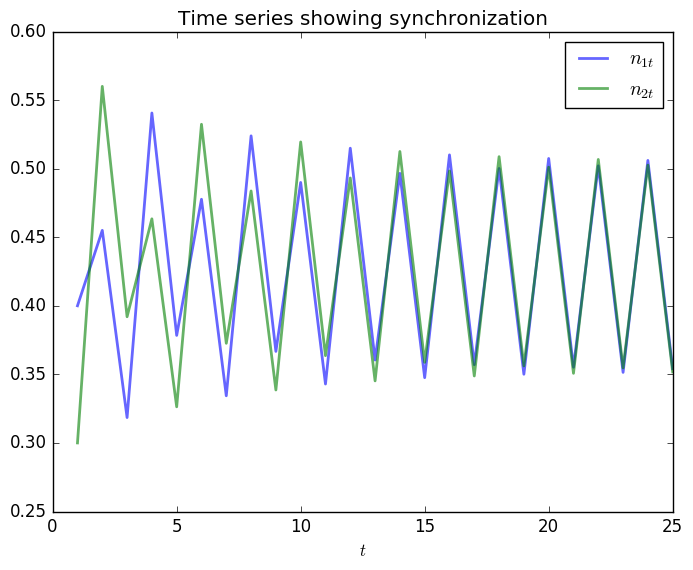

PyObject <matplotlib.legend.Legend object at 0x0000000029303E80>

In [6]:
n = generate_n(.4,.3,.6)
fig, ax = subplots()
ax[:plot](1:T, vec(n[1,:]), linewidth=2, alpha=.6, label=L"$n_{1t}$")
ax[:plot](1:T, vec(n[2,:]), linewidth=2, alpha=.6, label=L"$n_{2t}$")
ax[:set_xlabel](L"$t$")
ax[:set_title]("Time series showing synchronization")
ax[:legend]()

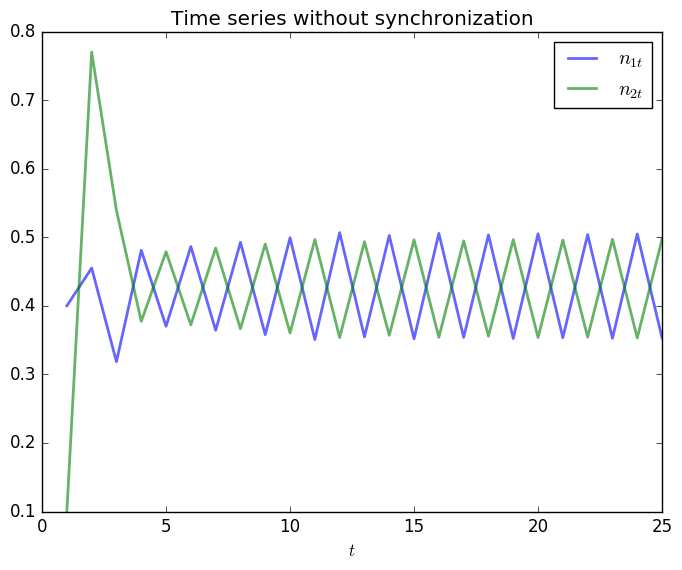

PyObject <matplotlib.legend.Legend object at 0x0000000024C9ACF8>

In [7]:
n = generate_n(.4,.1,.6)
fig, ax = subplots()
ax[:plot](1:T, vec(n[1,:]), linewidth=2, alpha=.6, label=L"$n_{1t}$")
ax[:plot](1:T, vec(n[2,:]), linewidth=2, alpha=.6, label=L"$n_{2t}$")
ax[:set_xlabel](L"$t$")
ax[:set_title]("Time series without synchronization")
ax[:legend]()

Define a function that computes the speed of synchronization of series $n_{1,t}$ and $n_{2,t}$ as a function of initial conditions $n_{1,0}$ and $n_{2,0}$ and the parameter $\rho$. Then plot a contour map of the range of initial conditions that deliver various speeds of synchronization, for various values of $\rho$. 

In [8]:
function is_synchronized(n1_init::Float64, n2_init::Float64, rho::Float64; 
    s1::Float64=.5, theta::Float64=2.5, delta::Float64=0.7, T::Int64=25, tol_synchronize::Float64=1e-2)
    
    n = generate_n(n1_init, n2_init, rho, s1=s1, theta=theta, delta=delta, T=T)
    n_diff = n[1,:] - n[2,:]
    synchronized = falses(T)
    for t in 3:T
        synchronized[t] = (n_diff[t] < tol_synchronize && n_diff[t-1] < tol_synchronize && n_diff[t-2] < tol_synchronize)
    end
    speed_synchronize = sum(synchronized.==true)
    return speed_synchronize
end

is_synchronized (generic function with 1 method)

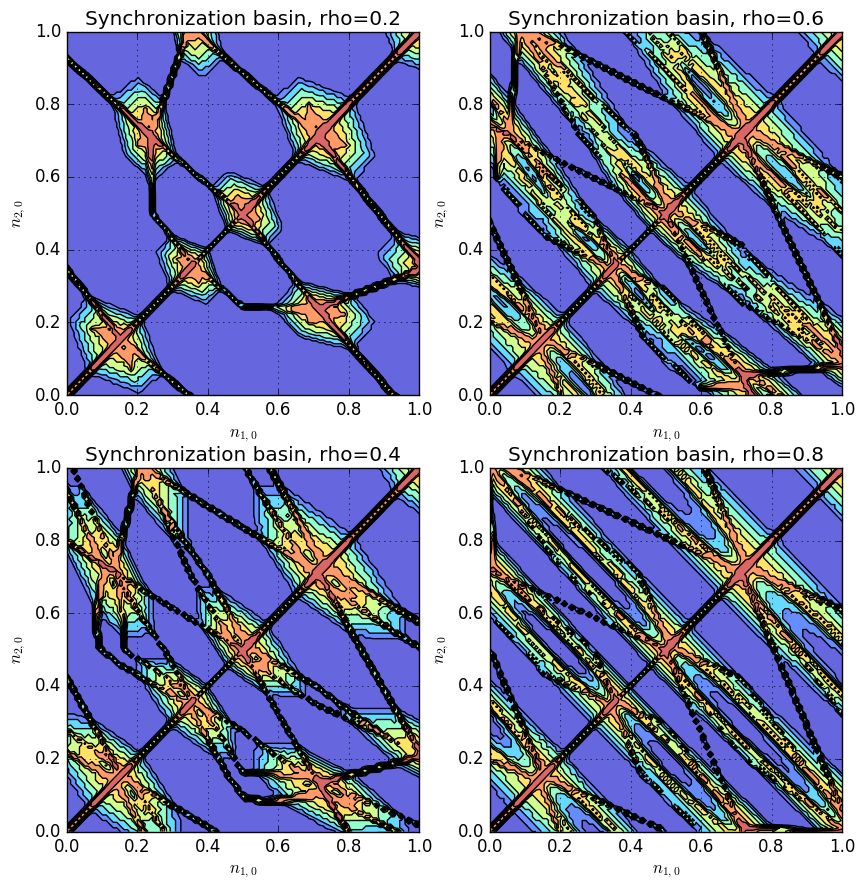

In [9]:
# == Set up grid for plotting == #
x_grid = linspace(0,1, 100)
y_grid = linspace(0, 1, 100)
X, Y = meshgrid(x_grid, y_grid)

fig, axes = subplots(2,2, figsize=(10, 10))
j = 1
for rho in rho_range
    ax = axes[j]
    ax[:xaxis][:grid](true, zorder=0)
    ax[:yaxis][:grid](true, zorder=0)
    Z = Float64[is_synchronized(n1,n2,rho) for n1 in x_grid, n2 in y_grid]
    ax[:contourf](X, Y, Z, 8, alpha=0.6, cmap=ColorMap("jet"))
    cs = ax[:contour](X, Y, Z, 8, colors="black")
    ax[:set_xlabel](L"$n_{1,0}$")
    ax[:set_ylabel](L"$n_{2,0}$")
    ax[:set_title]("Synchronization basin, rho=$rho")
    j += 1
end